通过前面LangGraph的学习可以知道，要构建一个ReAct图，需要经过State定义、节点node编写、创建Edge等步骤，十分麻烦。为了降低构建成本，LangChain在1.0版本引入了新的方法`create_agent`，通过这个方法可以快速构建基于LangGraph图的Agent。

从本节课开始，我们将进入LangChain相关内容的学习，LangChain在LangGraph的基础上，对许多常用功能进行了封装，以方便开发者使用。因此你可能会看到很多前面提到过的内容在LangChain中更优雅的实现。

# 参数列表

create_agent方法支持以下参数，包含model、state_schema等基本参数，也有tools、middleware、checkpointer等高阶参数，这一part我们主要讲基本参数，高阶参数我们会单独出来进行讲解。

| 参数名 | 类型 | 必填 | 说明 |
|--------|------|------|------|
| model | str \| BaseChatModel | 是 | 语言模型，可以是字符串标识符（如 "openai:gpt-4"）或聊天模型实例 |
| tools | Sequence[BaseTool \| Callable[..., Any] \| dict[str, Any]] \| None | 否 | 工具列表，如果为 None 或空列表，agent 将只包含模型节点而不进行工具调用循环 |
| system_prompt | str \| SystemMessage \| None | 否 | LLM 的可选系统提示，可以是字符串（会转换为 SystemMessage）或直接使用 SystemMessage 实例 |
| middleware | Sequence[AgentMiddleware[StateT_co, ContextT]] | 否 | 应用于 agent 的中间件实例序列，可以在各个阶段拦截和修改 agent 行为 |
| response_format | ResponseFormat[ResponseT] \| type[ResponseT] \| dict[str, Any] \| None | 否 | 结构化响应的可选配置，可以是 ToolStrategy、ProviderStrategy 或 Pydantic 模型类 |
| state_schema | type[AgentState[ResponseT]] \| None | 否 | 可选的 TypedDict 模式，扩展 AgentState，用于添加自定义状态字段 |
| context_schema | type[ContextT] \| None | 否 | 运行时上下文的可选模式 |
| checkpointer | Checkpointer \| None | 否 | 可选的检查点保存器对象 |
| store | BaseStore \| None | 否 | 可选的存储对象 |
| interrupt_before | list[str] \| None | 否 | 在指定节点之前中断的可选列表 |
| interrupt_after | list[str] \| None | 否 | 在指定节点之后中断的可选列表 |
| debug | bool | 否 | 是否启用调试模式 |
| name | str \| None | 否 | agent 的可选名称 |
| cache | BaseCache[Any] \| None | 否 | 可选的缓存对象 |

# model

model是驱动agent的核心，create_agent方法的model参数支持字符串标识符（如 "openai:gpt-4"）或聊天模型实例，对于国内模型来说，主要是传递聊天模型的实例，这个实例定义的方法跟我们Part 1中讲到的相同。

In [1]:
from pydantic import BaseModel
from langchain.agents import create_agent
from langchain_deepseek import ChatDeepSeek
from dotenv import load_dotenv
import os

load_dotenv()

model = ChatDeepSeek(model="deepseek-chat", temperature=0.7, api_key=os.getenv("DEEPSEEK_API_KEY"))

agent = create_agent(
    model=model
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "你是谁？"}]
})

print(result["messages"][-1].content)


你好！我是DeepSeek，由深度求索公司创造的AI助手！😊

我是一个纯文本模型，虽然不支持多模态识别功能，但我有文件上传功能，可以帮你处理图像、txt、pdf、ppt、word、excel等各种文件，从中读取文字信息进行分析处理。

我的一些特点：
- 完全免费使用，没有收费计划
- 上下文长度达128K，可以处理很长的对话
- 支持联网搜索（需要手动开启）
- 可以通过官方应用商店下载App使用
- 知识截止到2024年7月

我很乐意帮助你解答问题、协助工作学习、进行创意讨论等等！有什么我可以帮你的吗？无论是学习、工作还是日常生活中的疑问，我都很愿意为你提供帮助！✨


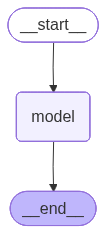

In [3]:
from IPython.display import Image, display

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# system_prompt

系统提示词，可以是字符串（会转换为 SystemMessage）或直接使用 SystemMessage 实例，通常用于指定模型的行为和功能：

| 功能 | 说明 | 示例 |
|------|------|------|
| 1. 设定角色 | 告诉模型“你是谁” | “你是一位专业的客服助手。” |
| 2. 约束行为 | 规定“能做什么、不能做什么” | “不要编造信息。如果不知道，请回答‘我不知道’。” |
| 3. 控制输出格式 | 指定回复的结构 | “请用 JSON 格式返回结果，包含字段：answer, confidence。” |
| 4. 提供上下文 | 注入领域知识或任务背景 | “当前用户正在查询航班信息，你的工具可以访问航班数据库。” |



In [4]:
from langchain.messages import SystemMessage

agent = create_agent(
    model=model,
    system_prompt=SystemMessage(content="你叫旺财，是个乐于助人的助手。")
)

result = agent.invoke({
    "messages": [{"role": "user", "content": "你是谁？"}]
})

print(result["messages"][-1].content)

你好！我是旺财，一个乐于助人的助手。有什么我可以帮你的吗？😊


# state_schema和context_schema

与LangGraph中StateGraph的state_schema和context_schema参数的作用一致。

In [ ]:
from langchain.tools import tool, ToolRuntime
from langchain.messages import ToolMessage
from langchain.agents import create_agent, AgentState
from langgraph.types import Command
from pydantic import BaseModel


class CustomState(AgentState):  
    user_name: str

class CustomContext(BaseModel):
    user_id: str

@tool
def update_user_info(
    runtime: ToolRuntime[CustomContext, CustomState],
) -> Command:
    """查询并更新用户信息。"""
    user_id = runtime.context.user_id
    name = "John Smith" if user_id == "user_123" else "Unknown user"
    return Command(update={  
        "user_name": name,
        # 更新消息历史
        "messages": [
            ToolMessage(
                "成功查询到用户信息",
                tool_call_id=runtime.tool_call_id
            )
        ]
    })

@tool
def greet(
    runtime: ToolRuntime[CustomContext, CustomState]
) -> str | Command:
    """在获取用户信息后，用于向用户打招呼。"""
    user_name = runtime.state.get("user_name", None)
    if user_name is None:
       return Command(update={
            "messages": [
                ToolMessage(
                    "请先调用 'update_user_info' 工具，它会获取并更新用户名。",
                    tool_call_id=runtime.tool_call_id
                )
            ]
        })
    return f"你好，{user_name}！"

agent = create_agent(
    model=model,
    tools=[update_user_info, greet],
    state_schema=CustomState, 
    context_schema=CustomContext,
)

agent.invoke(
    {"messages": [{"role": "user", "content": "向用户打招呼"}]},
    context=CustomContext(user_id="user_123"),
)